In [57]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD  # BU SATIR ÖNEMLİ!
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [35]:
# Load dataset
df = pd.read_csv("Reviews.csv")
# Keep only necessary columns
df = df[['UserId', 'ProductId', 'Score', 'Time']]
# Preview the first few rows
df.head()

,UserId,ProductId,Score,Time
0,A3SGXH7AUHU8GW,B001E4KFG0,5,1303862400
1,A1D87F6ZCVE5NK,B00813GRG4,1,1346976000
2,ABXLMWJIXXAIN,B000LQOCH0,4,1219017600
3,A395BORC6FGVXV,B000UA0QIQ,2,1307923200
4,A1UQRSCLF8GW1T,B006K2ZZ7K,5,1350777600


In [37]:
# Drop duplicates
df.drop_duplicates(inplace=True)


In [41]:
# Check dataset shape
print("Dataset shape:", df.shape)

Dataset shape: (565125, 4)


In [45]:
# Optional: Filter users with more than 10 reviews
user_counts = df['UserId'].value_counts()
df = df[df['UserId'].isin(user_counts[user_counts > 10].index)]


In [47]:
# Optional: Filter products with more than 10 reviews
product_counts = df['ProductId'].value_counts()
df = df[df['ProductId'].isin(product_counts[product_counts > 10].index)]

print("Filtered dataset shape:", df.shape)

Filtered dataset shape: (78725, 4)


In [49]:
user_product_matrix = df.pivot_table(index='UserId', columns='ProductId', values='Score')
user_product_matrix.fillna(0, inplace=True)

# Check dimensions
print("User-product matrix shape:", user_product_matrix.shape)


User-product matrix shape: (5756, 1533)


In [51]:
# Convert to sparse matrix
sparse_matrix = csr_matrix(user_product_matrix.values)

In [53]:
# Check if matrix has enough columns
num_features = user_product_matrix.shape[1]

In [59]:
if num_features > 1:
    n_components = min(20, num_features - 1)  # choose safely

    # Apply Truncated SVD
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    user_factors = svd.fit_transform(sparse_matrix)
    item_factors = svd.components_.T

    print("SVD applied. Shapes:")
    print("User factors:", user_factors.shape)
    print("Item factors:", item_factors.shape)
else:
    print("Matrix too small for SVD.")

SVD applied. Shapes:
User factors: (5756, 20)
Item factors: (1533, 20)


In [61]:
# Predict rating for user 0 and product 0
predicted_rating = np.dot(user_factors[0], item_factors[0])
print("Predicted rating:", predicted_rating)


Predicted rating: 0.002798556635123653


In [63]:
from sklearn.metrics import mean_squared_error


In [65]:
real_values = user_product_matrix.values.flatten()
predicted_values = np.dot(user_factors, item_factors.T).flatten()

rmse = np.sqrt(mean_squared_error(real_values, predicted_values))
print("RMSE:", rmse)

RMSE: 0.2948204686797421


In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:
# Calculate all predicted ratings (raw)
all_predicted = np.dot(user_factors, item_factors.T)

In [71]:
# Scale predicted ratings to 1-5 range
min_score, max_score = 1, 5
min_pred = all_predicted.min()
max_pred = all_predicted.max()

scaled_pred = min_score + (all_predicted - min_pred) * (max_score - min_score) / (max_pred - min_pred)


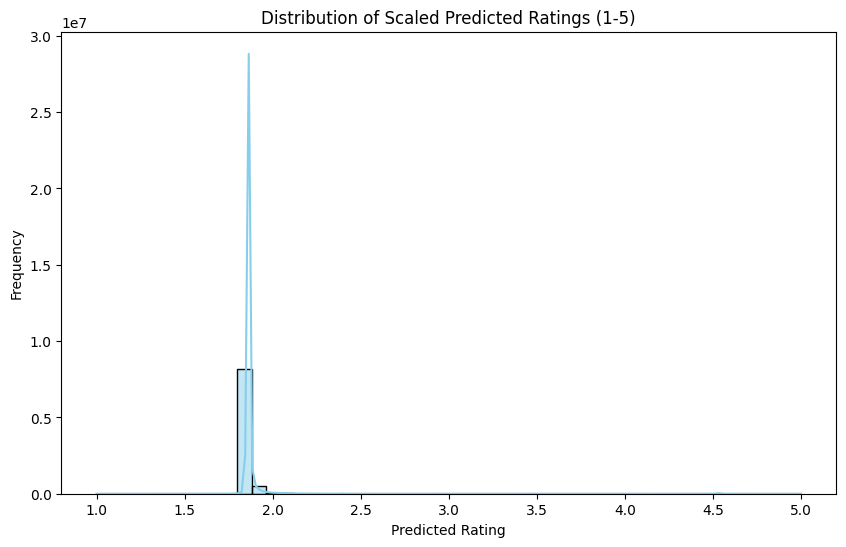

In [73]:
# Flatten and plot distribution
plt.figure(figsize=(10,6))
sns.histplot(scaled_pred.flatten(), bins=50, kde=True, color='skyblue')
plt.title('Distribution of Scaled Predicted Ratings (1-5)')
plt.xlabel('Predicted Rating')
plt.ylabel('Frequency')
plt.show()

C:\Users\aziz-\AppData\Local\Temp\ipykernel_21816\2744410128.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_counts.index, y=product_counts.values, palette='viridis')


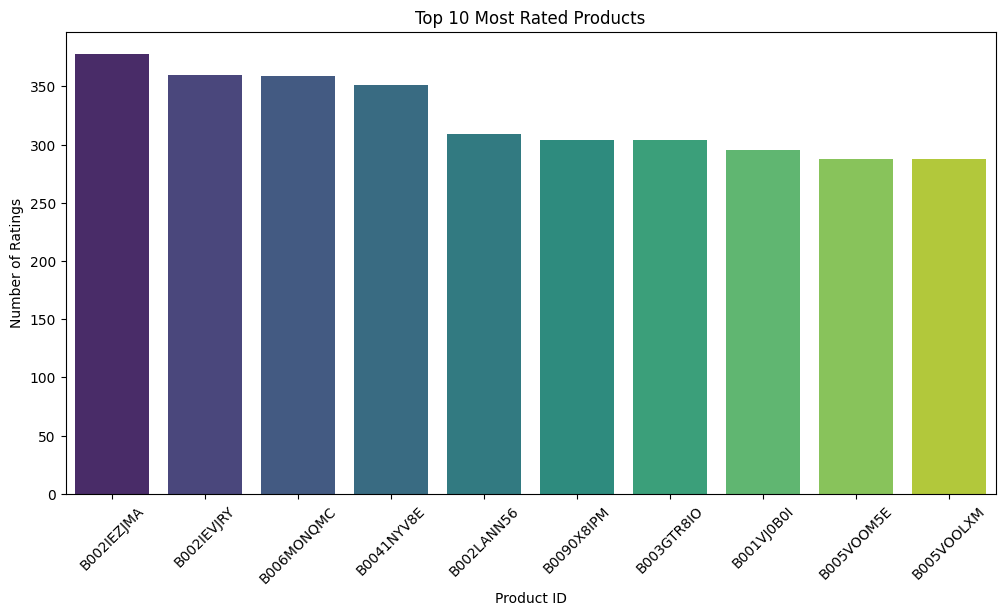

In [74]:
# Calculate number of ratings per product
product_counts = df['ProductId'].value_counts().head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=product_counts.index, y=product_counts.values, palette='viridis')
plt.title('Top 10 Most Rated Products')
plt.xlabel('Product ID')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.show()